In [ ]:
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers
from IPython.display import HTML
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping


from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
%cd /content/drive/MyDrive/project_AI
!unzip /content/drive/MyDrive/project_AI/dataset.zip

/content/drive/MyDrive/project_AI
Archive:  /content/drive/MyDrive/project_AI/dataset.zip
replace dataset/test_data/shipfire/302.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:

# declare path
train_dir = '/content/drive/MyDrive/project_AI/dataset/train_data/'
test_dir = '/content/drive/MyDrive/project_AI/dataset/test_data/'

# Image size

IMAGE_SIZE = (224,224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

BS = 32
EPOCHS = 100
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10

classes=['ship','shipfire']



In [ ]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

test_datagen  = ImageDataGenerator(rescale = 1./255)



In [ ]:
from sklearn.utils import shuffle
# Load dataset

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle = True,
                                                  batch_size = BS)



Found 789 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


In [ ]:
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

HTML(train_count.append(test_count).to_html(escape=False))

<ipython-input-5-dc897ff00aaa>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  HTML(train_count.append(test_count).to_html(escape=False))


,ship,shipfire
train,367,422
test,74,80


In [ ]:
# Data labels

class_labels = test_dataset.class_indices
class_labels

{'ship': 0, 'shipfire': 1}

In [ ]:
# See the shape of any data

train_sample=next(train_dataset)
print(train_sample[0].shape)

(32, 224, 224, 3)


In [ ]:
# VGG16

base_model = tf.keras.applications.VGG16(input_shape= IMAGE_SHAPE,include_top=False,weights="imagenet")
base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Freezing Layers

for layer in base_model.layers[:11]:
    layer.trainable=False


In [ ]:
# Build transfer learning Model

model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 7, 7, 512)        0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                        

In [ ]:
checkpoint = ModelCheckpoint("modelVGG.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [checkpoint,reduce_learningrate]

epochs = 30

model.compile(loss='binary_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
counter = Counter(train_dataset.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}

# lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
# mcp = ModelCheckpoint('modelVGG.h5')
# es = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = 20,
                  verbose =1,
                  callbacks = callbacks_list,
                  class_weight = class_weights)

Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 1.0610 - accuracy: 0.7959

25/25 [==============================] - 237s 9s/step - loss: 1.0610 - accuracy: 0.7959 - val_loss: 4.9789 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 0.6495 - accuracy: 0.9506

25/25 [==============================] - 18s 706ms/step - loss: 0.6495 - accuracy: 0.9506 - val_loss: 2.0687 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.9556

25/25 [==============================] - 19s 735ms/step - loss: 0.5940 - accuracy: 0.9556 - val_loss: 1.9294 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 4/20
25/25 [==============================] - ETA: 0s - loss: 0.5011 - accuracy: 0.9785

25/25 [==============================] - 17s 693ms/step - loss: 0.5011 - accuracy: 0.9785 - val_loss: 0.9705 - val_accuracy: 0.5467 - lr: 0.0010
Epoch 5/20
25/25 [==============================] - ETA: 0s - loss: 0.4584 - accuracy: 0.9785

25/25 [==============================] - 18s 730ms/step - loss: 0.4584 - accuracy: 0.9785 - val_loss: 0.6088 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 6/20
25/25 [==============================] - ETA: 0s - loss: 0.4803 - accuracy: 0.9734

25/25 [==============================] - 17s 688ms/step - loss: 0.4803 - accuracy: 0.9734 - val_loss: 0.5723 - val_accuracy: 0.8933 - lr: 0.0010
Epoch 7/20
25/25 [==============================] - ETA: 0s - loss: 0.4054 - accuracy: 0.9823

25/25 [==============================] - 17s 686ms/step - loss: 0.4054 - accuracy: 0.9823 - val_loss: 0.6426 - val_accuracy: 0.8600 - lr: 0.0010
Epoch 8/20
25/25 [==============================] - ETA: 0s - loss: 0.3628 - accuracy: 0.9899

25/25 [==============================] - 18s 727ms/step - loss: 0.3628 - accuracy: 0.9899 - val_loss: 0.4330 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 9/20
25/25 [==============================] - ETA: 0s - loss: 0.3486 - accuracy: 0.9899

25/25 [==============================] - 17s 685ms/step - loss: 0.3486 - accuracy: 0.9899 - val_loss: 0.3486 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 10/20
25/25 [==============================] - ETA: 0s - loss: 0.3315 - accuracy: 0.9899

25/25 [==============================] - 19s 749ms/step - loss: 0.3315 - accuracy: 0.9899 - val_loss: 1.0740 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 11/20
25/25 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.9886

25/25 [==============================] - 17s 694ms/step - loss: 0.3208 - accuracy: 0.9886 - val_loss: 0.2847 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 12/20
25/25 [==============================] - ETA: 0s - loss: 0.3640 - accuracy: 0.9645

25/25 [==============================] - 18s 738ms/step - loss: 0.3640 - accuracy: 0.9645 - val_loss: 3.0180 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 13/20
25/25 [==============================] - ETA: 0s - loss: 0.2983 - accuracy: 0.9848

25/25 [==============================] - 18s 693ms/step - loss: 0.2983 - accuracy: 0.9848 - val_loss: 0.2609 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 14/20
25/25 [==============================] - ETA: 0s - loss: 0.2747 - accuracy: 0.9911

25/25 [==============================] - 17s 689ms/step - loss: 0.2747 - accuracy: 0.9911 - val_loss: 0.2831 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 15/20
25/25 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.9911

25/25 [==============================] - 19s 751ms/step - loss: 0.2588 - accuracy: 0.9911 - val_loss: 0.2293 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 16/20
25/25 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.9772

25/25 [==============================] - 18s 700ms/step - loss: 0.2920 - accuracy: 0.9772 - val_loss: 1.1774 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 17/20
25/25 [==============================] - ETA: 0s - loss: 0.2598 - accuracy: 0.9810

25/25 [==============================] - 19s 779ms/step - loss: 0.2598 - accuracy: 0.9810 - val_loss: 2.8768 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 18/20
25/25 [==============================] - ETA: 0s - loss: 0.2443 - accuracy: 0.9772


Epoch 18: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
25/25 [==============================] - 17s 680ms/step - loss: 0.2443 - accuracy: 0.9772 - val_loss: 0.2688 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 19/20
25/25 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.9911

25/25 [==============================] - 17s 693ms/step - loss: 0.2171 - accuracy: 0.9911 - val_loss: 0.2199 - val_accuracy: 0.9867 - lr: 2.0000e-04
Epoch 20/20
25/25 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9962

25/25 [==============================] - 19s 756ms/step - loss: 0.1984 - accuracy: 0.9962 - val_loss: 0.1877 - val_accuracy: 1.0000 - lr: 2.0000e-04


In [ ]:
%cd /content/drive/MyDrive/project_AI
model.save('modelVgg16_au.h5')

/content/drive/MyDrive/project_AI


In [ ]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

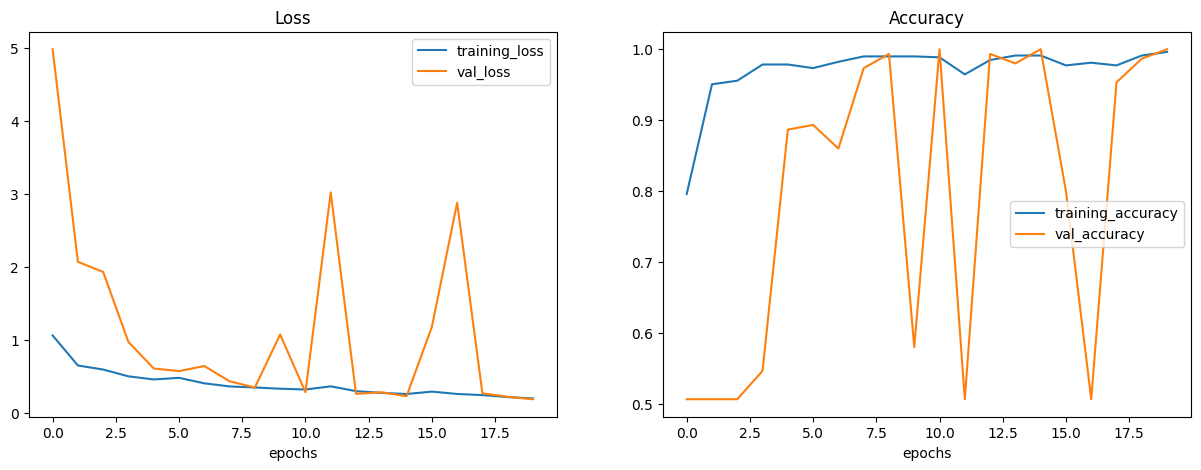

In [ ]:
plot_curves(history)

In [ ]:
Xtest = []
ytest = []
dict = {'ship':[0,1],'shipfire':[1,0]}
TEST_DATA = "/content/drive/MyDrive/project_AI/dataset/test_data"
for whatever in os.listdir(TEST_DATA):
  whatever_path =  os.path.join(TEST_DATA, whatever)
  lst_filename_path = []
  for filename in os.listdir(whatever_path):
    filename_path = os.path.join(whatever_path, filename)
    lable = filename_path.split('/')[-2]
    img = Image.open(filename_path)
    img = img.resize((224,224))
    img = np.array(img)
    lst_filename_path.append((img,dict[lable]))
  Xtest.extend(lst_filename_path)


In [ ]:
arr = np.array([x[0] for _, x in enumerate(Xtest)])
md = models.load_model("/content/drive/MyDrive/project_AI/modelVgg16_au.h5")
Vgg16_Predictions = md.predict(arr[::-1])

# Choosing highest probalbilty class in every prediction
Vgg16_Predictions = np.argmax(Vgg16_Predictions,axis = 1)
print(Vgg16_Predictions)
print(test_dataset.labels)


5/5 [==============================] - 1s 120ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
